# Introduction
This worksheet focuses on Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). You will:

- Build and experiment with CNN architectures for image‑based tasks, learning how convolution, pooling, and feature extraction work in practice, and comparing your results with equivalent PyTorch implementations.

- Implement and train RNN‑based models- LSTMs, or GRUs—for sequence data, exploring how these networks capture temporal patterns and how different architectures affect performance.

# 0. Preliminaries
We firstly import the libraries required for this worksheet: NumPy for numerical computations, Matplotlib for plotting, and PyTorch for building and training models.

In [1]:
##TODO
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
import torchvision
import torchvision.transforms as transforms

C:\Users\rohta\miniconda3\envs\text_analytics\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Convolutional Neural Network (CNN)  
In this question, you will build and train a convolutional neural network using PyTorch to classify images from the CIFAR‑10 dataset.
CIFAR‑10 contains 60,000 colour images across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
Each image is a 3‑channel (RGB) image of size 32×32 pixels.

In this question, you will:  
(a) Load and normalize the CIFAR10 training and test datasets using `torchvision`  
(b) Implement a CNN in PyTorch (e.g., using `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and fully connected layers).  
Train your network on the CIFAR‑10 training set using a suitable loss function and optimizer.  
(c) Evaluate the performance of your model on the test set using appropriate metrics (e.g., accuracy, precision). Plot the confusion matrix to visualise the performance of your classifier.  
(d) Implement the transfer learning approach using a pretrained model and compare the model performances.

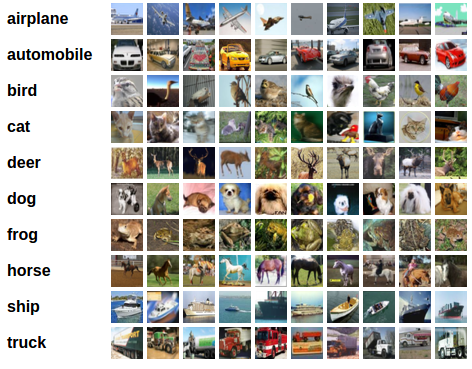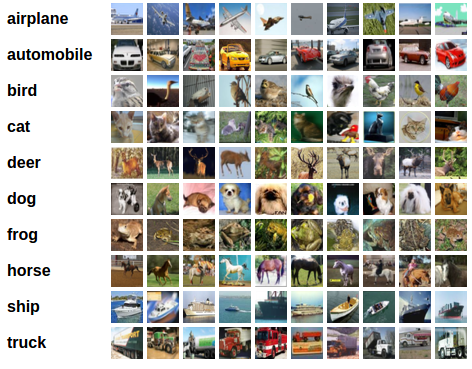

## Part (a)  
Load the CIFAR‑10 dataset using torchvision.datasets together with the given transformation. Use this transform when creating both the training and test sets.

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load CIFAR-10 training and test sets
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_subset = torch.utils.data.Subset(trainset, range(8000))
test_subset  = torch.utils.data.Subset(testset,  range(2000))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Inspect the dataset to understand its structure. Determine how many training images are contained in trainset.

Examine the shape of a single image by checking the .shape attribute of a batch from `trainloader` (e.g., by iterating once and printing the tensor shape).

Look at the target labels and confirm that CIFAR‑10 contains 10 object categories (plane, car, bird, cat, deer, dog, frog, horse, ship, truck).

In [4]:
##TODO
print(len(trainset))
print(len(train_subset), len(test_subset))

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

print(len(classes))
print(set(trainset.targets))


50000
8000 2000
torch.Size([32, 3, 32, 32])
torch.Size([32])
10
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## Part (b)
Implement a CNN in PyTorch (e.g., using `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and fully connected layers).    
Train your network on the CIFAR‑10 training set using a suitable loss function and optimizer.  

In [5]:
class CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution + pooling layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),   # conv1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, kernel_size=5),  # conv2
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),  # fc1
            nn.ReLU(),
            nn.Linear(120, 84),         # fc2
            nn.ReLU(),
            nn.Linear(84, 10)           # fc3 (10 classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Set up the CNN by specifying the parameters. Then create the model and prepare it for training by choosing an appropriate loss function (`CrossEntropyLoss` for multi‑class classification) and an optimizer (`Adam with a learning rate of 0.01).

In [6]:
def train_model(model, train_loader, test_loader, epochs=20, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    dev_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        dev_running = 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                dev_loss = criterion(outputs, labels)
                dev_running += dev_loss.item()

        avg_dev_loss = dev_running / len(test_loader)
        dev_losses.append(avg_dev_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_dev_loss:.4f}")

    return train_losses, dev_losses


In [7]:
model1 = CNN_Net()
_ = train_model(model1, trainloader, testloader, epochs=10, lr=1e-3)

Epoch 1/10 | Train Loss: 1.9577 | Val Loss: 1.8346
Epoch 2/10 | Train Loss: 1.6742 | Val Loss: 1.5864
Epoch 3/10 | Train Loss: 1.5427 | Val Loss: 1.5383
Epoch 4/10 | Train Loss: 1.4541 | Val Loss: 1.4930
Epoch 5/10 | Train Loss: 1.3802 | Val Loss: 1.4636
Epoch 6/10 | Train Loss: 1.3110 | Val Loss: 1.4354
Epoch 7/10 | Train Loss: 1.2567 | Val Loss: 1.4134
Epoch 8/10 | Train Loss: 1.1864 | Val Loss: 1.4017
Epoch 9/10 | Train Loss: 1.1294 | Val Loss: 1.3946
Epoch 10/10 | Train Loss: 1.0673 | Val Loss: 1.4009


Identify the epoch at which the validation loss stops decreasing.
- Validation loss stops decreasing first at epoch 6 and then stops decreasing again at epoch 10.

## Part (c) 
Evaluate the performance of your model on the test set using appropriate metrics (e.g., accuracy, precision).  
Plot the confusion matrix to visualise the performance of your classifier.

0.5155
              precision    recall  f1-score   support

       plane       0.50      0.52      0.51       196
         car       0.56      0.64      0.60       198
        bird       0.47      0.33      0.39       195
         cat       0.37      0.29      0.32       199
        deer       0.38      0.51      0.43       198
         dog       0.50      0.38      0.43       185
        frog       0.68      0.62      0.65       216
       horse       0.65      0.59      0.61       193
        ship       0.54      0.71      0.61       217
       truck       0.53      0.53      0.53       203

    accuracy                           0.52      2000
   macro avg       0.52      0.51      0.51      2000
weighted avg       0.52      0.52      0.51      2000



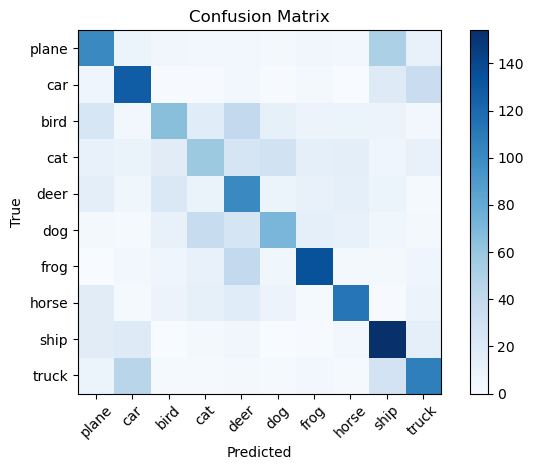

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
correct = 0
total = 0
all_preds = []
all_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model1(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
print(accuracy)
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [9]:
#TODO
# Compute recall per class
recalls = cm.diagonal() / cm.sum(axis=1)

# Pair with class names
class_performance = list(zip(classes, recalls))

# Sort descending
class_performance_sorted = sorted(class_performance, key=lambda x: x[1], reverse=True)

class_performance_sorted

[('ship', 0.7096774193548387),
 ('car', 0.6414141414141414),
 ('frog', 0.6203703703703703),
 ('horse', 0.5854922279792746),
 ('truck', 0.5270935960591133),
 ('plane', 0.5153061224489796),
 ('deer', 0.51010101010101),
 ('dog', 0.3837837837837838),
 ('bird', 0.3333333333333333),
 ('cat', 0.2914572864321608)]

## Part d
- Implement a transfer‑learning approach using a pretrained model from torchvision.models (e.g., ResNet50).
- Fine‑tune the model on CIFAR‑10.
- Compare its performance with your CNN.

In [10]:
import torchvision.models as models

# --- Load pretrained ResNet50 ---
model2 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# --- Freeze all layers ---
for param in model2.parameters():
    param.requires_grad = False

# --- Replace final fully connected layer for CIFAR‑10 ---
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, 10)

Train the ResNet model and identify the optimal number of epochs required for best performance.

In [11]:
_ = train_model(model2, trainloader, testloader, epochs=5, lr=1e-3)

Epoch 1/5 | Train Loss: 2.0154 | Val Loss: 1.8773
Epoch 2/5 | Train Loss: 1.7793 | Val Loss: 2.2182
Epoch 3/5 | Train Loss: 1.7105 | Val Loss: 1.9117
Epoch 4/5 | Train Loss: 1.6596 | Val Loss: 1.7602
Epoch 5/5 | Train Loss: 1.6456 | Val Loss: 1.7458


Evaluate the performance of your model on the test set using appropriate metrics (e.g., accuracy, precision).  
Plot the confusion matrix to visualise the performance of your classifier.

ResNet Test Accuracy: 0.4355


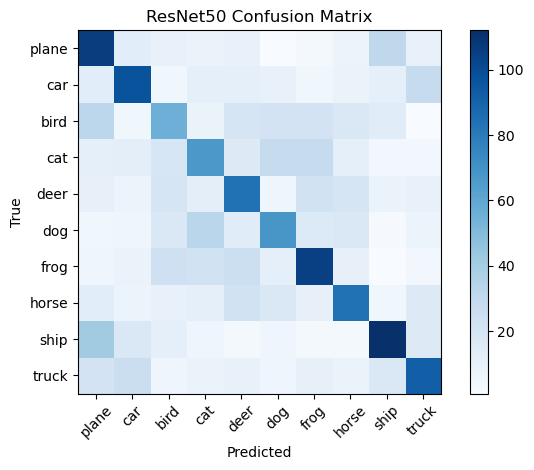

In [12]:
##TODO
correct = 0
total = 0
all_preds = []
all_labels = []

model2.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = model2(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print("ResNet Test Accuracy:", accuracy)

cm = confusion_matrix(all_labels, all_preds)

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet50 Confusion Matrix")
plt.tight_layout()
plt.show()



Compare the performances of the two models. Modify the hyperparameters to improve the performance of both models.

# 2 Recurrent Neural Networks
In this section, we now build and compare two recurrent architectures: LSTM and GRU for time‑series forecasting using the Jena Climate dataset.
The goal is to predict future temperature values based on historical climate measurements.

In this task, you will:   
(a) Load & Visualise the Dataset (Jena Climate)  
(b) Split the dataset into training and test sets.
Convert both splits into PyTorch tensors or wrap them in TensorDataset + DataLoader.  
(c) Implement LSTM, and GRU Models.
Train each model for several epochs and record the training and validation losses.  
(d) Evaluate the Models  
(e) Visualise Results

# Part (a)  Load & Visualise the Dataset (Jena Climate)
- Download the data either manually from [Kaggle](https://www.kaggle.com/datasets/mnassrib/jena-climate) or by using the `kagglehub.dataset_download`  
- Load the CSV file  
- Read the climate data into a pandas DataFrame.  
- Convert "Date Time" into a proper datetime object and set it as the index.

In [13]:
import kagglehub
import pandas as pd
import os

## Download dataset
path = kagglehub.dataset_download("mnassrib/jena-climate")
csv_path = os.path.join(path, "jena_climate_2009_2016.csv")
df = pd.read_csv(csv_path)

# Parse datetime column and set as index
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")
df = df.set_index("Date Time")
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


The original Jena Climate dataset records measurements every 10 minutes. For many forecasting tasks, this resolution is unnecessarily fine and makes the dataset much larger than needed.  
Hence, we will downsample the data by taking every 6th row. which would give $6×10\text{ minutes}=60\text{ minutes}$  
Plot the hourly temperature series

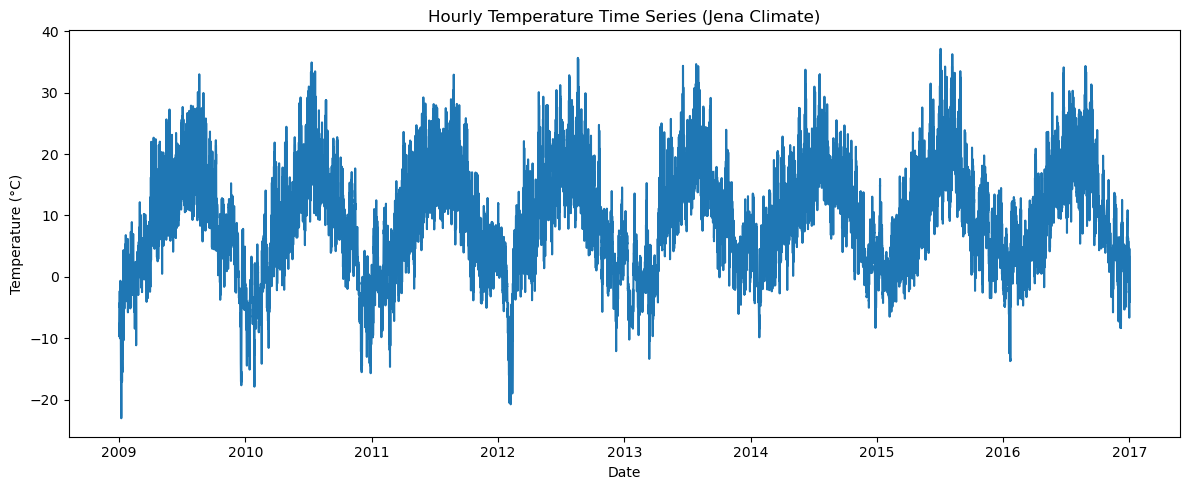

In [14]:
df = df.iloc[::6].copy()
# Plot
##TODO
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["T (degC)"])
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Hourly Temperature Time Series (Jena Climate)")
plt.tight_layout()
plt.show()

# Part (b) Prepare Sequential Data for RNN Models
- Divide the data into 80/20\% split for training and testing while maintaining chronological order. 
- Apply Standard Scaling
- Convert the time‑series into supervised samples using a sliding window:
    Input: the previous lookback timesteps (5 days of history);
    Output: the target variable (the temperature "T (degC)") at the next timestep.
- Convert to PyTorch tensors and create DataLoaders.

Train / validation / test split (chronological)

Time-series samples are not i.i.d.; random splitting leaks “future” patterns into training and breaks the forecasting assumption.

In [15]:
values = df.values.astype(np.float32)

n_total = int(len(values)*0.2)
n_train = int(0.80 * n_total)
n_test = n_total - n_train

train = values[:n_train]
test= values[n_train:n_total]

print("Total:", n_total)
print("Train:", train.shape, "Test:", test.shape)

Total: 14018
Train: (11214, 14) Test: (2804, 14)


RNNs train more effectively when inputs are normalised.  
We fit the scaler on the training portion only, then transform both train and test sets.

In [16]:
from sklearn.preprocessing import StandardScaler
##TODO
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Sequence construction  

We predict temperature at time t using the previous 5 days (hourly): lookback = 24*5 = 120.

In [17]:
def make_sequences(data, lookback, target_col):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, :])
        y.append(data[i, target_col])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
lookback = 24 * 5
target_col = df.columns.get_loc("T (degC)")

Xtr, Ytr = make_sequences(train_scaled, lookback, target_col)
Xte, Yte = make_sequences(test_scaled, lookback, target_col)

We need to convert our data into PyTorch‑compatible tensors so the model can train on it. PyTorch cannot operate directly on NumPy arrays — it requires tensors, which are optimized for automatic differentiation and efficient computation on both CPUs and GPUs.

In [18]:
##TODO
Xtr_t = torch.from_numpy(Xtr)
Ytr_t = torch.from_numpy(Ytr)

Xte_t = torch.from_numpy(Xte)
Yte_t = torch.from_numpy(Yte)

We wrap the tensors in TensorDataset and DataLoader to enable efficient mini‑batch training.

In [19]:
from torch.utils.data import TensorDataset, DataLoader
batch_size=64
# Create datasets
train_ds = TensorDataset(Xtr_t, Ytr_t)
test_ds   = TensorDataset(Xte_t, Yte_t)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader   = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# (c) Implement LSTM, and GRU Models

- Define a LSTM and GRU models. Use either `nn.LSTM` or `nn.GRU` to process sequential input and `nn.Linear` to map the final hidden state to a single regression output (next‑step temperature). Both models take input of shape:(batch, sequence length, features) and output a single temperature value for each sample.
- Train each model using `nn.CrossEntropyLoss()` and `optim.Adam()` for ~30 epochs:
- Track training and validation loss
- Plot training curves.

In [20]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)          # out: (batch, seq_len, hidden_dim)
        last = out[:, -1, :]          # last timestep: (batch, hidden_dim)
        y_hat = self.fc(last)         # (batch, 1)
        return y_hat


In [22]:
class GRU_model(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        y_hat = self.fc(last)
        return y_hat


In [27]:
def train_model(model, train_loader, test_loader, epochs=20, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # ---- TRAINING ----
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch).squeeze()
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                val_pred = model(X_batch).squeeze()
                val_loss = criterion(val_pred, y_batch)
                val_running += val_loss.item()

        avg_val_loss = val_running / len(test_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1:02d}: train={avg_train_loss:.6f}, val={avg_val_loss:.6f}")

    # ---- PLOT ----
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training curves")
    plt.legend()
    plt.show()

    return train_losses, val_losses

Epoch 01: train=0.183690, val=0.095087
Epoch 02: train=0.027770, val=0.062515
Epoch 03: train=0.026821, val=0.034202
Epoch 04: train=0.013677, val=0.034012
Epoch 05: train=0.011986, val=0.029620
Epoch 06: train=0.010931, val=0.025750
Epoch 07: train=0.010115, val=0.023846
Epoch 08: train=0.009581, val=0.023637
Epoch 09: train=0.009974, val=0.026648
Epoch 10: train=0.011638, val=0.024951
Epoch 11: train=0.010755, val=0.021475
Epoch 12: train=0.008399, val=0.019291
Epoch 13: train=0.007724, val=0.018775
Epoch 14: train=0.007680, val=0.018511
Epoch 15: train=0.007604, val=0.018530
Epoch 16: train=0.007637, val=0.018543
Epoch 17: train=0.007652, val=0.018664
Epoch 18: train=0.007667, val=0.018895
Epoch 19: train=0.007884, val=0.022453
Epoch 20: train=0.009646, val=0.024670


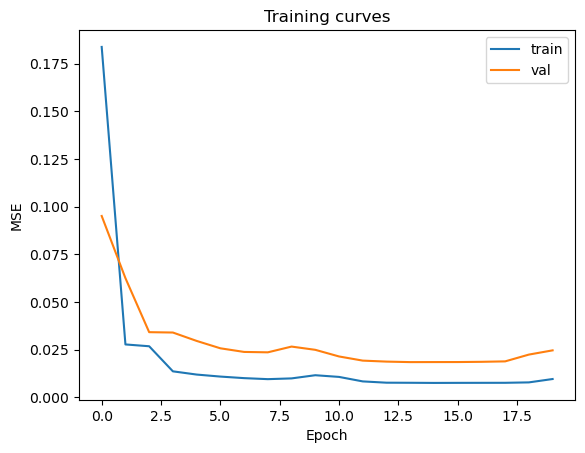

In [28]:
input_dim = Xtr_t.shape[2]

lstm = LSTM_model(input_dim=input_dim, hidden_dim=64)
_ = train_model(lstm, train_loader, test_loader, epochs=20, lr=1e-3)

Epoch 01: train=0.118737, val=0.037146
Epoch 02: train=0.022134, val=0.026004
Epoch 03: train=0.014355, val=0.034939
Epoch 04: train=0.012150, val=0.034905
Epoch 05: train=0.010992, val=0.031168
Epoch 06: train=0.010084, val=0.028042
Epoch 07: train=0.009507, val=0.025829
Epoch 08: train=0.009110, val=0.024142
Epoch 09: train=0.008826, val=0.022751
Epoch 10: train=0.008626, val=0.021622
Epoch 11: train=0.008494, val=0.020745
Epoch 12: train=0.008411, val=0.020064
Epoch 13: train=0.008358, val=0.019512
Epoch 14: train=0.008318, val=0.019057
Epoch 15: train=0.008284, val=0.018676
Epoch 16: train=0.008253, val=0.018345
Epoch 17: train=0.008221, val=0.018043
Epoch 18: train=0.008185, val=0.017763
Epoch 19: train=0.008143, val=0.017513
Epoch 20: train=0.008098, val=0.017321


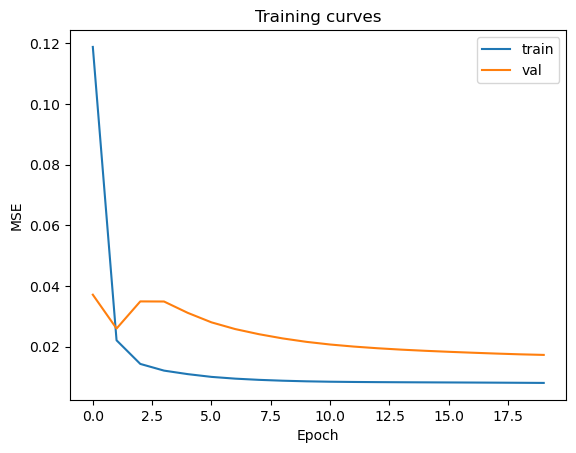

In [29]:
gru = GRU_model(input_dim=input_dim, hidden_dim=64)
_ = train_model(gru, train_loader, test_loader, epochs=20, lr=1e-3)

# (d) Evaluate the Models
For each model:

- Predict on test set  
- Invert scaling  
- Compute RMSE 

Because we used StandardScaler on all features, the target scaling is:  
$y_\text{scaled} = \frac{y - \mu}{\sigma}\Rightarrow y = y_\text{scaled}\sigma + \mu$

So we can invert temperature using `scaler.mean_[target_col]` and `scaler.scale_[target_col]`.

In [30]:
from sklearn.metrics import mean_squared_error
target_mean = scaler.mean_[target_col]
target_std = scaler.scale_[target_col]

def inverse_temp(y_scaled):
    return y_scaled * target_std + target_mean

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

def evaluate_model(model, X, Y, name="Model"):
    model.eval()
    with torch.no_grad():
        yhat_scaled = model(X).detach().numpy().reshape(-1)
        y_scaled = Y.detach().numpy().reshape(-1)

    yhat = inverse_temp(yhat_scaled)
    ytrue = inverse_temp(y_scaled)
    
    score = rmse(ytrue, yhat)
    print(f"{name} Test RMSE: {score:.3f} °C")
    return ytrue, yhat, score

ytrue_lstm, yhat_lstm, rmse_lstm = evaluate_model(lstm, Xte_t, Yte_t, name="LSTM")
ytrue_gru, yhat_gru, rmse_gru = evaluate_model(gru, Xte_t, Yte_t, name="GRU")

LSTM Test RMSE: 1.392 °C
GRU Test RMSE: 1.166 °C


## Part (e) Visualise Results

Predicted vs actual temperature curves


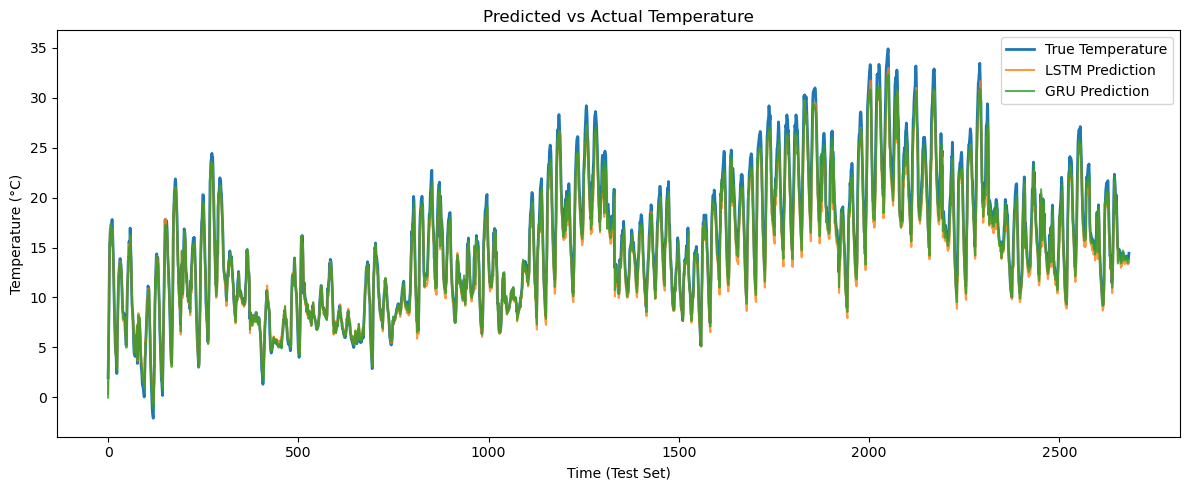

In [31]:
#TODO
plt.figure(figsize=(12,5))

plt.plot(ytrue_lstm, label="True Temperature", linewidth=2)
plt.plot(yhat_lstm, label="LSTM Prediction", alpha=0.8)
plt.plot(yhat_gru, label="GRU Prediction", alpha=0.8)

plt.xlabel("Time (Test Set)")
plt.ylabel("Temperature (°C)")
plt.title("Predicted vs Actual Temperature")
plt.legend()
plt.tight_layout()
plt.show()

Which converged faster? 
Which generalised better? What will you modify to improve the performance of the models?